<a href="https://colab.research.google.com/github/manasi1096/Change-colors-in-image/blob/main/ChangecolorsviaHSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from sklearn.cluster import KMeans
from collections import Counter
import cv2
from PIL import Image

In [83]:
img = imread('/content/chair.jpeg')/255

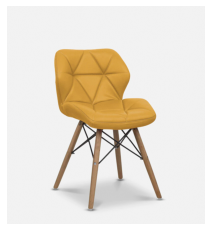

In [84]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [85]:
img.shape

(880, 800, 3)

In [86]:
image_2D = np.reshape(img, (img.shape[0]*img.shape[1],3))

In [87]:
kmeans = KMeans(n_clusters = 6, random_state=0)
labels = kmeans.fit_predict(image_2D)

In [88]:
color_counts = Counter(labels)

In [89]:
color_counts.values()

dict_values([550657, 28639, 66606, 29667, 22723, 5708])

In [90]:
kmeans.cluster_centers_

array([[0.94829203, 0.94824131, 0.94812488],
       [0.72108157, 0.51948413, 0.2016482 ],
       [0.54631697, 0.43238127, 0.33049389],
       [0.81014867, 0.80686798, 0.80239304],
       [0.19599555, 0.16714239, 0.14850244],
       [0.84190315, 0.62897417, 0.27504305]])

In [91]:
kmeans.cluster_centers_[3]*255

array([206.58791074, 205.75133568, 204.61022453])

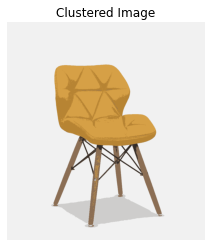

In [92]:
clustered = kmeans.cluster_centers_[labels]
clustered_3D = clustered.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(clustered_3D)
plt.title('Clustered Image')
plt.axis('off')
plt.show()

In [93]:
clustered[0]

array([0.94829203, 0.94824131, 0.94812488])

In [94]:


def RGB2HEX(color):
  color = color*255
  return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [95]:
# hex_colors = []
# for i in kmeans.cluster_centers_:
#   hex_colors.append(RGB2HEX(i))

hex_colors = [RGB2HEX(i) for i in kmeans.cluster_centers_]


In [96]:
# hex_colors_labels = []

# for i,j in enumerate(range(len(kmeans.cluster_centers_))):
#   hex_colors_labels.append((i, RGB2HEX(kmeans.cluster_centers_[j])))

hex_colors_labels = [(i, RGB2HEX(kmeans.cluster_centers_[j])) for i,j in enumerate(range(len(kmeans.cluster_centers_)))]

In [97]:
color_values = [color_counts[key] for key in sorted(color_counts.keys())]

In [98]:
color_counts

Counter({0: 550657, 1: 29667, 2: 22723, 3: 28639, 4: 5708, 5: 66606})

In [99]:
550657+36143 + 6562

593362

([<matplotlib.patches.Wedge at 0x7f0e37cd3790>,
 [Text(-0.8523537666766186, 0.6953366497116203, "(0, '#f1f1f1')"),
  Text(0.3612324672041139, -1.03899523802452, "(1, '#b78433')"),
  Text(0.592105058278509, -0.9270445512277193, "(2, '#8b6e54')"),
  Text(0.7872455830558558, -0.7682736439310187, "(3, '#cecdcc')"),
  Text(0.8953116094754493, -0.6390752083585161, "(4, '#312a25')"),
  Text(1.0517669940555616, -0.3221586413792567, "(5, '#d6a046')")])

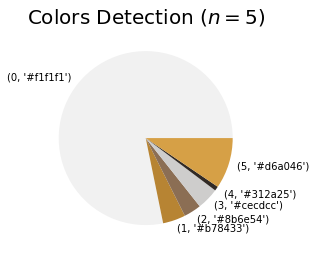

In [100]:
plt.title('Colors Detection ($n=5$)', fontsize=20)
plt.pie(color_values, labels = hex_colors_labels, colors = hex_colors)  


In [102]:
pip install webcolors

In [103]:
non_chair_seat_idx = [i for i,label in enumerate(labels) if (label !=5 and label!=1 )]
len(non_chair_seat_idx)


607727

In [104]:
image2D_copy = image_2D.copy()
image2D_copy[non_chair_seat_idx] = image2D_copy[non_chair_seat_idx]*0

In [105]:
image2D_copy

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

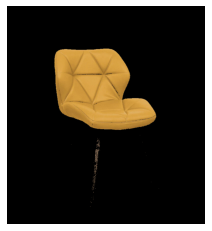

In [106]:
recons_only_seat = image2D_copy.reshape(img.shape)
plt.axis('off')
plt.imshow(recons_only_seat)

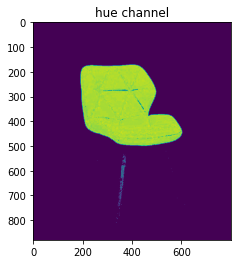

In [107]:
# plotting the image now
#all of the region at once but in the HSV space
im = Image.fromarray((recons_only_seat*255).astype(np.uint8))
onlyseat_hsv = cv2.cvtColor(np.float32(im), cv2.COLOR_RGB2HSV)

hue = onlyseat_hsv[:,:,0]  #Extracting hue channel

# plotting hue channel
plt.title('hue channel')
plt.imshow(hue)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


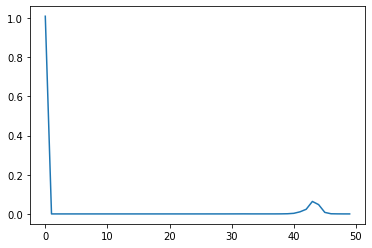

In [108]:
# check the hue intensity of seat 
hist, _ = np.histogram(hue, bins=50, normed=True)
plt.plot(hist)
plt.show()

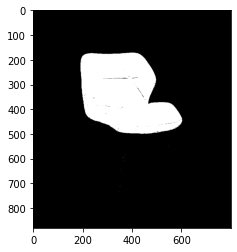

In [109]:
h =  43 # hue value
t = 10 # tolerance value

# creating a binary mask 
min_hue = np.array([h - t])
max_hue = np.array([h + t])

mask_hue = cv2.inRange(hue, min_hue, max_hue)

# visualise the mask
plt.imshow(mask_hue, cmap='gray')

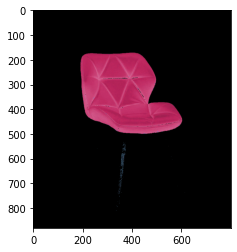

In [110]:
# modfiy value for non 0 pixels 
hue[mask_hue > 0] = hue[mask_hue > 0] + 120 # 120 because 43 + 120 = 160 which is purple/pink; wanted chaire to be purple/pink

# assign the modified hue channel back to the hsv image
onlyseat_hsv[:,:,0] = hue

im_final = cv2.cvtColor(onlyseat_hsv, cv2.COLOR_HSV2RGB)
plt.imshow((im_final * 255).astype(np.uint8))

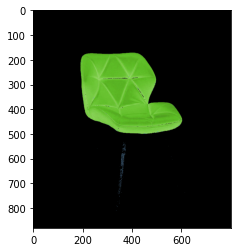

In [113]:
# modfiy value for non 0 pixels 
hue[mask_hue > 0] = hue[mask_hue > 0] + 120 # 120 because 43 + 120 = 160 which is purple/pink; wanted chaire to be purple/pink

# assign the modified hue channel back to the hsv image
onlyseat_hsv[:,:,0] = hue

im_final = cv2.cvtColor(onlyseat_hsv, cv2.COLOR_HSV2RGB)
plt.imshow((im_final * 255).astype(np.uint8))

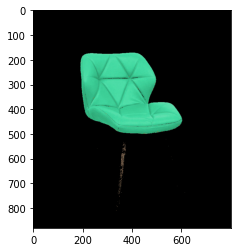

In [116]:
# modfiy value for non 0 pixels 
hue[mask_hue > 0] = hue[mask_hue > 0] + 120 # 120 because 43 + 120 = 160 which is purple/pink; wanted chaire to be purple/pink

# assign the modified hue channel back to the hsv image
onlyseat_hsv[:,:,0] = hue

im_final = cv2.cvtColor(onlyseat_hsv, cv2.COLOR_HSV2RGB)/255
plt.imshow((im_final))

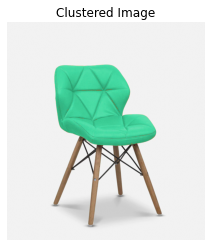

In [118]:
im_final_flat = im_final.reshape(im_final.shape[0]*im_final.shape[1], im_final.shape[2])
image_2D[np.where(im_final_flat!=0)] =  im_final_flat[np.where(im_final_flat!=0)]

clustered_3D_new = image_2D.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(clustered_3D_new)
plt.title('Clustered Image')
plt.axis('off')
plt.show()